In [1]:
# notebook for the prm check
import pandas as pd
import numpy as np
import lifelines as ll
import sksurv as sks
import matplotlib.pyplot as plt
from bart_survival import surv_bart as sb
# from bart_survival import simulation as sm
import lifelines as ll
from lifelines import KaplanMeierFitter
import subprocess
import importlib

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import sys
sys.path.append("../py/")
sys.path.append("../src/")
import _conditions1 as cn
import _functions1 as fn
import _sim_iter1 as si
import _plot_fx as pltf
import sim_adj as sm

In [17]:
# SCENARIO = {
#     "type": "prm",
#     "x_vars": 3, 
#     "VAR_CLASS": [2,2],
#     "VAR_PROB":[.5,.5],
#     # "scale_f": "2.5*x_mat[:,0]",
#     "scale_f": "10 + 0.8*x_mat[:,0] - 1.2 * x_mat[:,1]",
#     "shape_f": "3 - 1.5 * x_mat[:,0]",
#     "cens_scale":None
# }
SCENARIO = {
    "type": "param_check_1",
    "x_vars": 10, 
    "VAR_CLASS": [2,2,1,1,1],
    "VAR_PROB":[.5,.5,None,None,None],
    # "scale_f": "2.5*x_mat[:,0]",
    "scale_f": "10 + 0.8*x_mat[:,0] - .4*x_mat[:,0]*x_mat[:,2] -.4*x_mat[:,1] + .2*x_mat[:,2] - .2 * x_mat[:,3] + .2 * x_mat[:,4]",
    "shape_f": "2.5 - 1.1 * x_mat[:,0] -.4 * x_mat[:,1]",
    "cens_scale":None
}

SPLT_R = [
    "pmb.ContinuousSplitRule()", # time
    "pmb.OneHotSplitRule()",
    "pmb.OneHotSplitRule()",
    "pmb.ContinuousSplitRule()",
    "pmb.ContinuousSplitRule()",
    "pmb.ContinuousSplitRule()", 
    "pmb.ContinuousSplitRule()", # addl
    "pmb.ContinuousSplitRule()", 
    "pmb.ContinuousSplitRule()", 
    "pmb.ContinuousSplitRule()", 
    "pmb.ContinuousSplitRule()", 
]

# SPLT_R = [
#     "pmb.ContinuousSplitRule()",
#     "pmb.OneHotSplitRule()",
#     "pmb.ContinuousSplitRule()",
#     "pmb.ContinuousSplitRule()"
# ]

EXP_NAME = "param_eval1"
RUN_NAME = "param_run1"
N = 400
TREES = [10,25,50,100,200]
TUNE = [10,100,1000]
DRAW = [250, 500, 1000, 2000]
CHAINS = 5
SEED_ADDL=99
ITERS = 10

idx = 0
MDICT = {
	"trees":TREES[idx],
	"split_rules": SPLT_R
}
SDICT = {
	"draws": DRAW[idx],
	"tune": TUNE[idx],
	"cores": CHAINS,
	"chains": CHAINS,
	"compute_convergence_checks":False
}

In [232]:
importlib.reload(fn)

<module '_functions1' from '/Users/jacobtiegs/projects/bart_paper/bart_survival_paper/notebook/../py/_functions1.py'>

In [18]:
# meta, sv_true, pb_sv = fn.sim_prm_1s(
# x_mat, event_dict, sv_true = fn.sim_prm_1s(
# ev2 = fn.sim_prm_1s(
sv_true, pb_sv, uniq_t, stats, intvs = fn.sim_prm_1s(
	seed=SEED_ADDL, 
	n=N, 
	scenario_=SCENARIO, 
	SPLIT_RULES=SPLT_R, 
	model_dict=MDICT, 
	sampler_dict=SDICT
	)

mean shape 1.6869999999999998
mean scale 10.409677000000002
60.0
mean time draws 9.83813053161131
good sim


Only 250 samples in chain.
Multiprocess sampling (5 chains in 5 jobs)
PGBART: [f]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Sampling 5 chains for 10 tune and 250 draw iterations (50 + 1_250 draws total) took 21 seconds.
Sampling: [f]


In [35]:
import arviz as az

In [258]:
stats["cov_ci"].tolist()

[1.0, 1.0, 1.0, 0.7725, 0.525, 0.525, 0.525]

In [19]:
sv_truet = sv_true["sv_true"][:,(uniq_t-1).astype("int")]
pb_svm = pb_sv["sv"].mean(0)

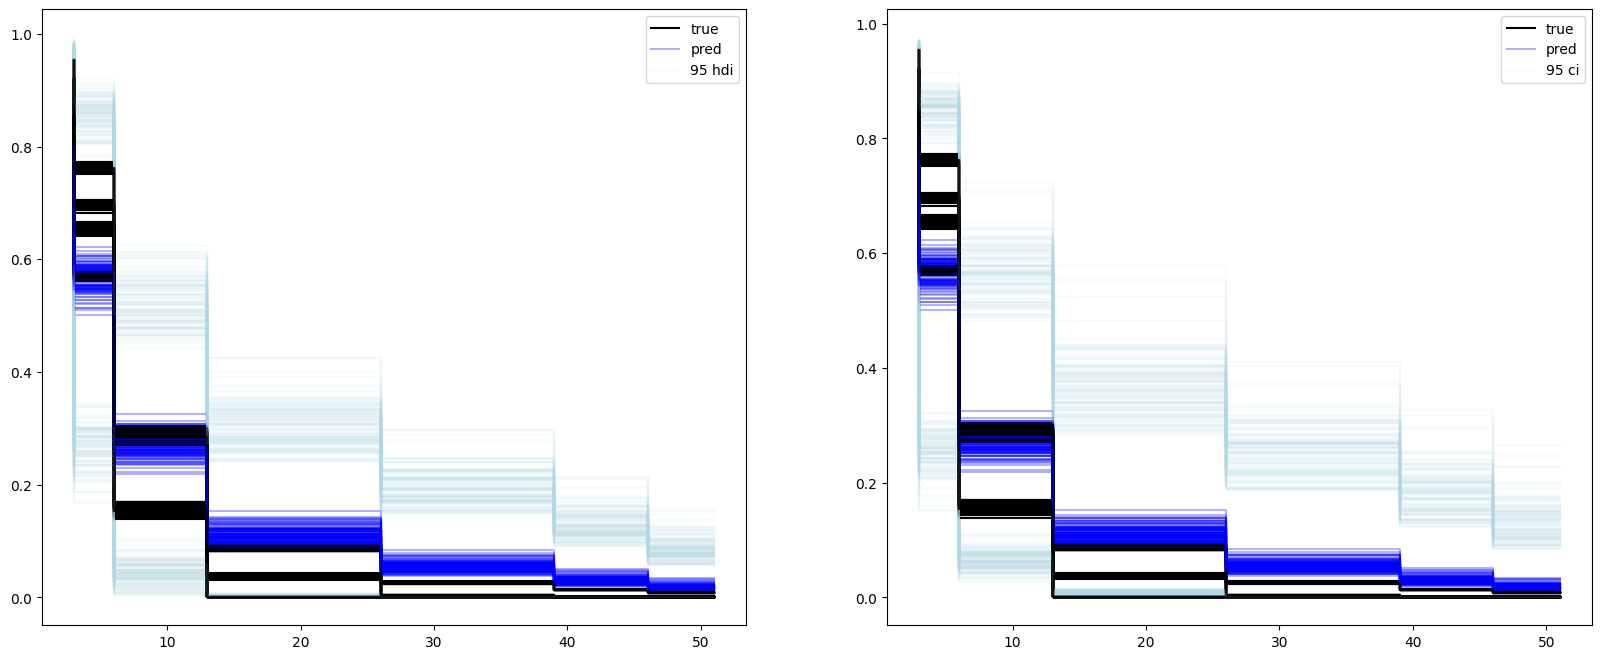

In [20]:
fig,ax = plt.subplots(1,2, figsize=(20,8))
for i in range(100):
	if i == 0:
		ax[0].step(uniq_t, sv_truet[i,:], color="black", label = "true")
		ax[1].step(uniq_t, sv_truet[i,:], color="black", label= "true")

		ax[0].step(uniq_t, pb_svm[i,:], color = "blue", alpha=0.3, label="pred")
		ax[1].step(uniq_t, pb_svm[i,:], color = "blue", alpha=0.3, label = "pred")

		ax[0].step(uniq_t, intvs[0][i, :, 0], color="lightblue", alpha=0.1, label = "95 hdi")
		ax[0].step(uniq_t, intvs[0][i, :, 1], color= "lightblue", alpha=0.1)
		
		ax[1].step(uniq_t, intvs[1][0, i, :], color="lightblue", alpha=0.1, label = "95 ci")
		ax[1].step(uniq_t, intvs[1][1, i, :], color= "lightblue", alpha=0.1)
		ax[0].legend()
		ax[1].legend()
	else:
		ax[0].step(uniq_t, sv_truet[i,:], color="black")
		ax[1].step(uniq_t, sv_truet[i,:], color="black")

		ax[0].step(uniq_t, pb_svm[i,:], color = "blue", alpha=0.3)
		ax[1].step(uniq_t, pb_svm[i,:], color = "blue", alpha=0.3)

		ax[0].step(uniq_t, intvs[0][i, :, 0], color="lightblue", alpha=0.1)
		ax[0].step(uniq_t, intvs[0][i, :, 1], color= "lightblue", alpha=0.1)
		
		ax[1].step(uniq_t, intvs[1][0, i, :], color="lightblue", alpha=0.1)
		ax[1].step(uniq_t, intvs[1][1, i, :], color= "lightblue", alpha=0.1)
	

In [243]:
intvs[0]

array([[8.04197526e-01, 9.99823233e-01],
       [6.23800143e-01, 9.92057135e-01],
       [3.21602384e-01, 8.34498314e-01],
       [1.23712323e-02, 4.17605324e-01],
       [2.14698061e-04, 2.23245954e-01],
       [3.42395574e-09, 1.33202811e-01],
       [1.49772711e-14, 9.05793189e-02]])

In [194]:
zzz = az.convert_to_dataset(pb_sv["sv"].reshape(1,1250,400,7))
zzz2 = az.hdi(zzz, hdi_prob=.95).x.values
ci = np.quantile(pb_sv["sv"], [0.025, 0.975], 0)
sv_true_t=sv_true["sv_true"][:,(uniq_t-1).astype("int")]

(400, 7, 2)

In [195]:
ttot = []
for i in range(7):
	t1 = (np.round(zzz2[:,i,0],4) <= np.round(sv_true_t[:,i],4))  & (np.round(sv_true_t[:,i],4) <= np.round(zzz2[:,i,1],4))
	# t1 = (zzz2[:,i,0] <= sv_true_t[:,i])  & (sv_true_t[:,i] <= zzz2[:,i,1])
	ttot.append(t1)
# print(t1)
# print(zzz2[t1 == False, i,0][0])
# print(sv_true_t[t1==False,i][0])
np.array(ttot).T.sum(0)

array([400, 400, 400, 400, 390, 400, 400])

In [221]:
# np.abs(ci[0,:,:]- ci[1,:,:]).mean(0)
# np.abs(zzz2[:,:,0] - zzz2[:,:,1]).mean(0)

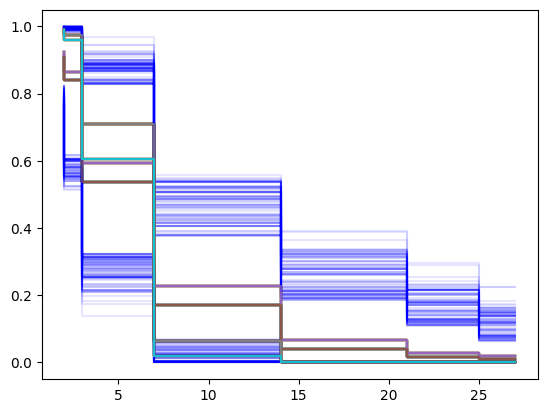

In [201]:
for i in range(100):
	plt.step(uniq_t, zzz2[i,:,0], color="blue", alpha=0.1)
	plt.step(uniq_t, zzz2[i,:,1], color="blue", alpha=0.1)
	# plt.step(uniq_t, pb_sv["sv"].mean(0)[i,:])
	# plt.step(uniq_t, ci[0,i,:], color="blue",alpha=.5)
	# plt.step(uniq_t, ci[1,i,:], color="blue",alpha=.5)
	plt.step(uniq_t, sv_true_t[i,:])